# `Asap.jl`
Another structural analysis package. Developed for ease-of-information extraction after matrix analysis of structural systems. Stores internal forces, displacements, and connectivities of constituent nodes and elements for downstream analysis and processing. Let's make a structure!

In [1]:
using Asap

There are 4 main data types with the following key fields:

1. `Node`: position, degrees of freedom
2. `Element`: node connectivity, material properties
3. `Load`: position, force magnitudes
4. `Structure`: nodes, elements, and loads

We will walk through the same structure in `example3d.jl`. First, defining the nodes. We can create a new `Node` by inputting the global position and degrees of freedom for the given node. 2D/3D, truss/frame is parsed based on the length of the position and DOF vectors:

`n = Node([position1, position2 (, position3)], [dof1, dof2 (,dof3,...)])`

In [24]:
node1 = Node([72.0, 0.0, 0.0], [true, false, true])
node2 = Node([0.0, 36.0, 0.0], [false, false, false])
node3 = Node([0.0, 36.0, 72.0], [false, false, false])
node4 = Node([0.0, 0.0, -48.0], [false, false, false])

Node([0.0, 0.0, -48.0], Bool[0, 0, 0], 0.0, 0.0, -48.0, #undef, #undef, #undef, Tuple{Int64, Int64}[], #undef)

Since there are common DOF restrictions for most analysis types (pinned, free, fixed, etc.), you can also use predefined symbol combinations of structure type (truss/frame) and node fixity. Node fixities include `:fixed, pinned, xfixed, xfree, pinfixed`, where `xfree` and `xfixed` can be replaced with `y` and `z` respectively. The following is an equivalent definition of nodes:

In [25]:
node1 = Node([72.0, 0.0, 0.0], :truss, :yfixed)
node2 = Node([0.0, 36.0, 0.0], :truss, :fixed)
node3 = Node([0.0, 36.0, 72.0], :truss, :fixed)
node4 = Node([0.0, 0.0, -48.0], :truss, :fixed)

Node([0.0, 0.0, -48.0], Bool[0, 0, 0], 0.0, 0.0, -48.0, #undef, #undef, #undef, Tuple{Int64, Int64}[], #undef)

We create a vector of nodes:

In [26]:
nodes = [node1, node2, node3, node4];

Next, we define the elements. They are created by `Element(nodes, [connectivity], materialProperties...)`

1. `[connectivity]` is a length 2 vector of start and end node positions with respect to the `nodes` vector.
2. `materialProperties` is a varied length of relevant material property values. They are in order: `E, A, G, Iz, Iy, J` or the modulus of elasticity, cross section area, shear constant, strong-axis moment of inertia, weak-axis moment of inertia, torsional constant. `E` and `A` are always needed for analysis. The rest depend on the dimensionality and type of structure you are analyzing. Defining only the material properties needed for your analysis will create the proper `Element` type.

We are analyzing a truss, so it suffices to define `E` and `A` only:

In [27]:
# Material properties
E = 1.2e6
A1 = 0.302
A2 = 0.729
A3 = 0.187

# Defining elements
element1 = Element(nodes, [1,2], E, A1)
element2 = Element(nodes, [1,3], E, A2)
element3 = Element(nodes, [1,4], E, A3)

Element([1, 4], :truss, [72.0, 0.0, 0.0], [0.0, 0.0, -48.0], 86.53323061113575, #undef, #undef, #undef, 1.072711702e-314, #undef, 0.187, 1.2e6, 1.073929222e-314, 1.072711781e-314, 1.0727118125e-314, 1.0727118283e-314, #undef)

Creating a vector of elements:

In [28]:
elements = [element1, element2, element3];

Next we define the loads. A `Load` structure has the same DOFs as the nodes under analysis, but with the relevant force/moment values instead of Boolean fixity values. They are defined by `Load(nodes, position, [forces])`. 

If we want to apply loads at a specific node, we can take advantage of the `.position` field for all nodes. Let's place a downwards (-Z) load on node 1:

In [29]:
load1 = Load(nodes, node1.position, [0., 0., -1000.])

Load([72.0, 0.0, 0.0], [0.0, 0.0, -1000.0], 1)

As always, we create a vector of loads:

In [30]:
loads = [load1]

1-element Vector{Load}:
 Load([72.0, 0.0, 0.0], [0.0, 0.0, -1000.0], 1)

Now we can assemble the structure using `Structure`:

In [31]:
structure = Structure(nodes, elements, loads);

We can then perform a linear elastic direct stiffness analysis of the structure:

In [32]:
analyze(structure)

When we analyze a structure, not only does the global displacement vector get calculated, the connectivity between nodes/elements are stored, internal force value fields are populated for elements, nodal displacements and reactions (if applicable) are stored, and a scaled deformation of the structure is stored. Let's look at the displacements:

In [33]:
displacements = structure.U

12-element Vector{Float64}:
 -0.07111435679043869
  0.0
 -0.26623909389254097
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

And the reactions:

In [34]:
structure.reactions

12-element Vector{Float64}:
    0.0
 -223.16320982432393
    0.0
  256.1226339189204
 -128.0613169594602
    0.0
 -702.4490535675682
  351.2245267837841
  702.4490535675682
  446.3264196486479
    0.0
  297.5509464324319

If we want to know the internal axial force for element 2:

In [35]:
e2_axialforce = element2.axialForce

1053.6735803513523

Or the reaction forces at node 3:

In [36]:
n3_reactions = node3.reaction

3-element Vector{Float64}:
 -702.4490535675682
  351.2245267837841
  702.4490535675682

If we want to visualize the structure, we first convert it into a `Geometry` type:

In [15]:
geo = Geometry(structure);

Geometry(Structure(Node[Node([72.0, 0.0, 0.0], Bool[1, 0, 1], 72.0, 0.0, 0.0, [0.0, 0.0, -1000.0], [0.0, -223.16320982432393, 0.0], [-0.07111435679043869, 0.0, -0.26623909389254097], [(1, -1), (2, -1), (3, -1)], [1, 2, 3]), Node([0.0, 36.0, 0.0], Bool[0, 0, 0], 0.0, 36.0, 0.0, #undef, [256.1226339189204, -128.0613169594602, 0.0], [0.0, 0.0, 0.0], [(1, 1)], [4, 5, 6]), Node([0.0, 36.0, 72.0], Bool[0, 0, 0], 0.0, 36.0, 72.0, #undef, [-702.4490535675682, 351.2245267837841, 702.4490535675682], [0.0, 0.0, 0.0], [(2, 1)], [7, 8, 9]), Node([0.0, 0.0, -48.0], Bool[0, 0, 0], 0.0, 0.0, -48.0, #undef, [446.3264196486479, 0.0, 297.5509464324319], [0.0, 0.0, 0.0], [(3, 1)], [10, 11, 12])], Element[Element([1, 2], :truss, [72.0, 0.0, 0.0], [0.0, 36.0, 0.0], 80.49844718999243, [3601.5601557596606 -1800.7800778798303 … 1800.7800778798303 0.0; -1800.7800778798303 900.3900389399151 … -900.3900389399151 0.0; … ; 1800.7800778798303 -900.3900389399151 … 900.3900389399151 0.0; 0.0 0.0 … 0.0 0.0], [1, 2, 3, 

This converts custom structures into easily plottable types. We can use `structurePlot` to visualize:

In [ ]:
fig = structurePlot(geo);
display(fig)

GLMakie.Screen(...)

Using `CairoMakie` will get nicer figures that are publication ready! This is a very simple structure (so less impressive), but we can do:

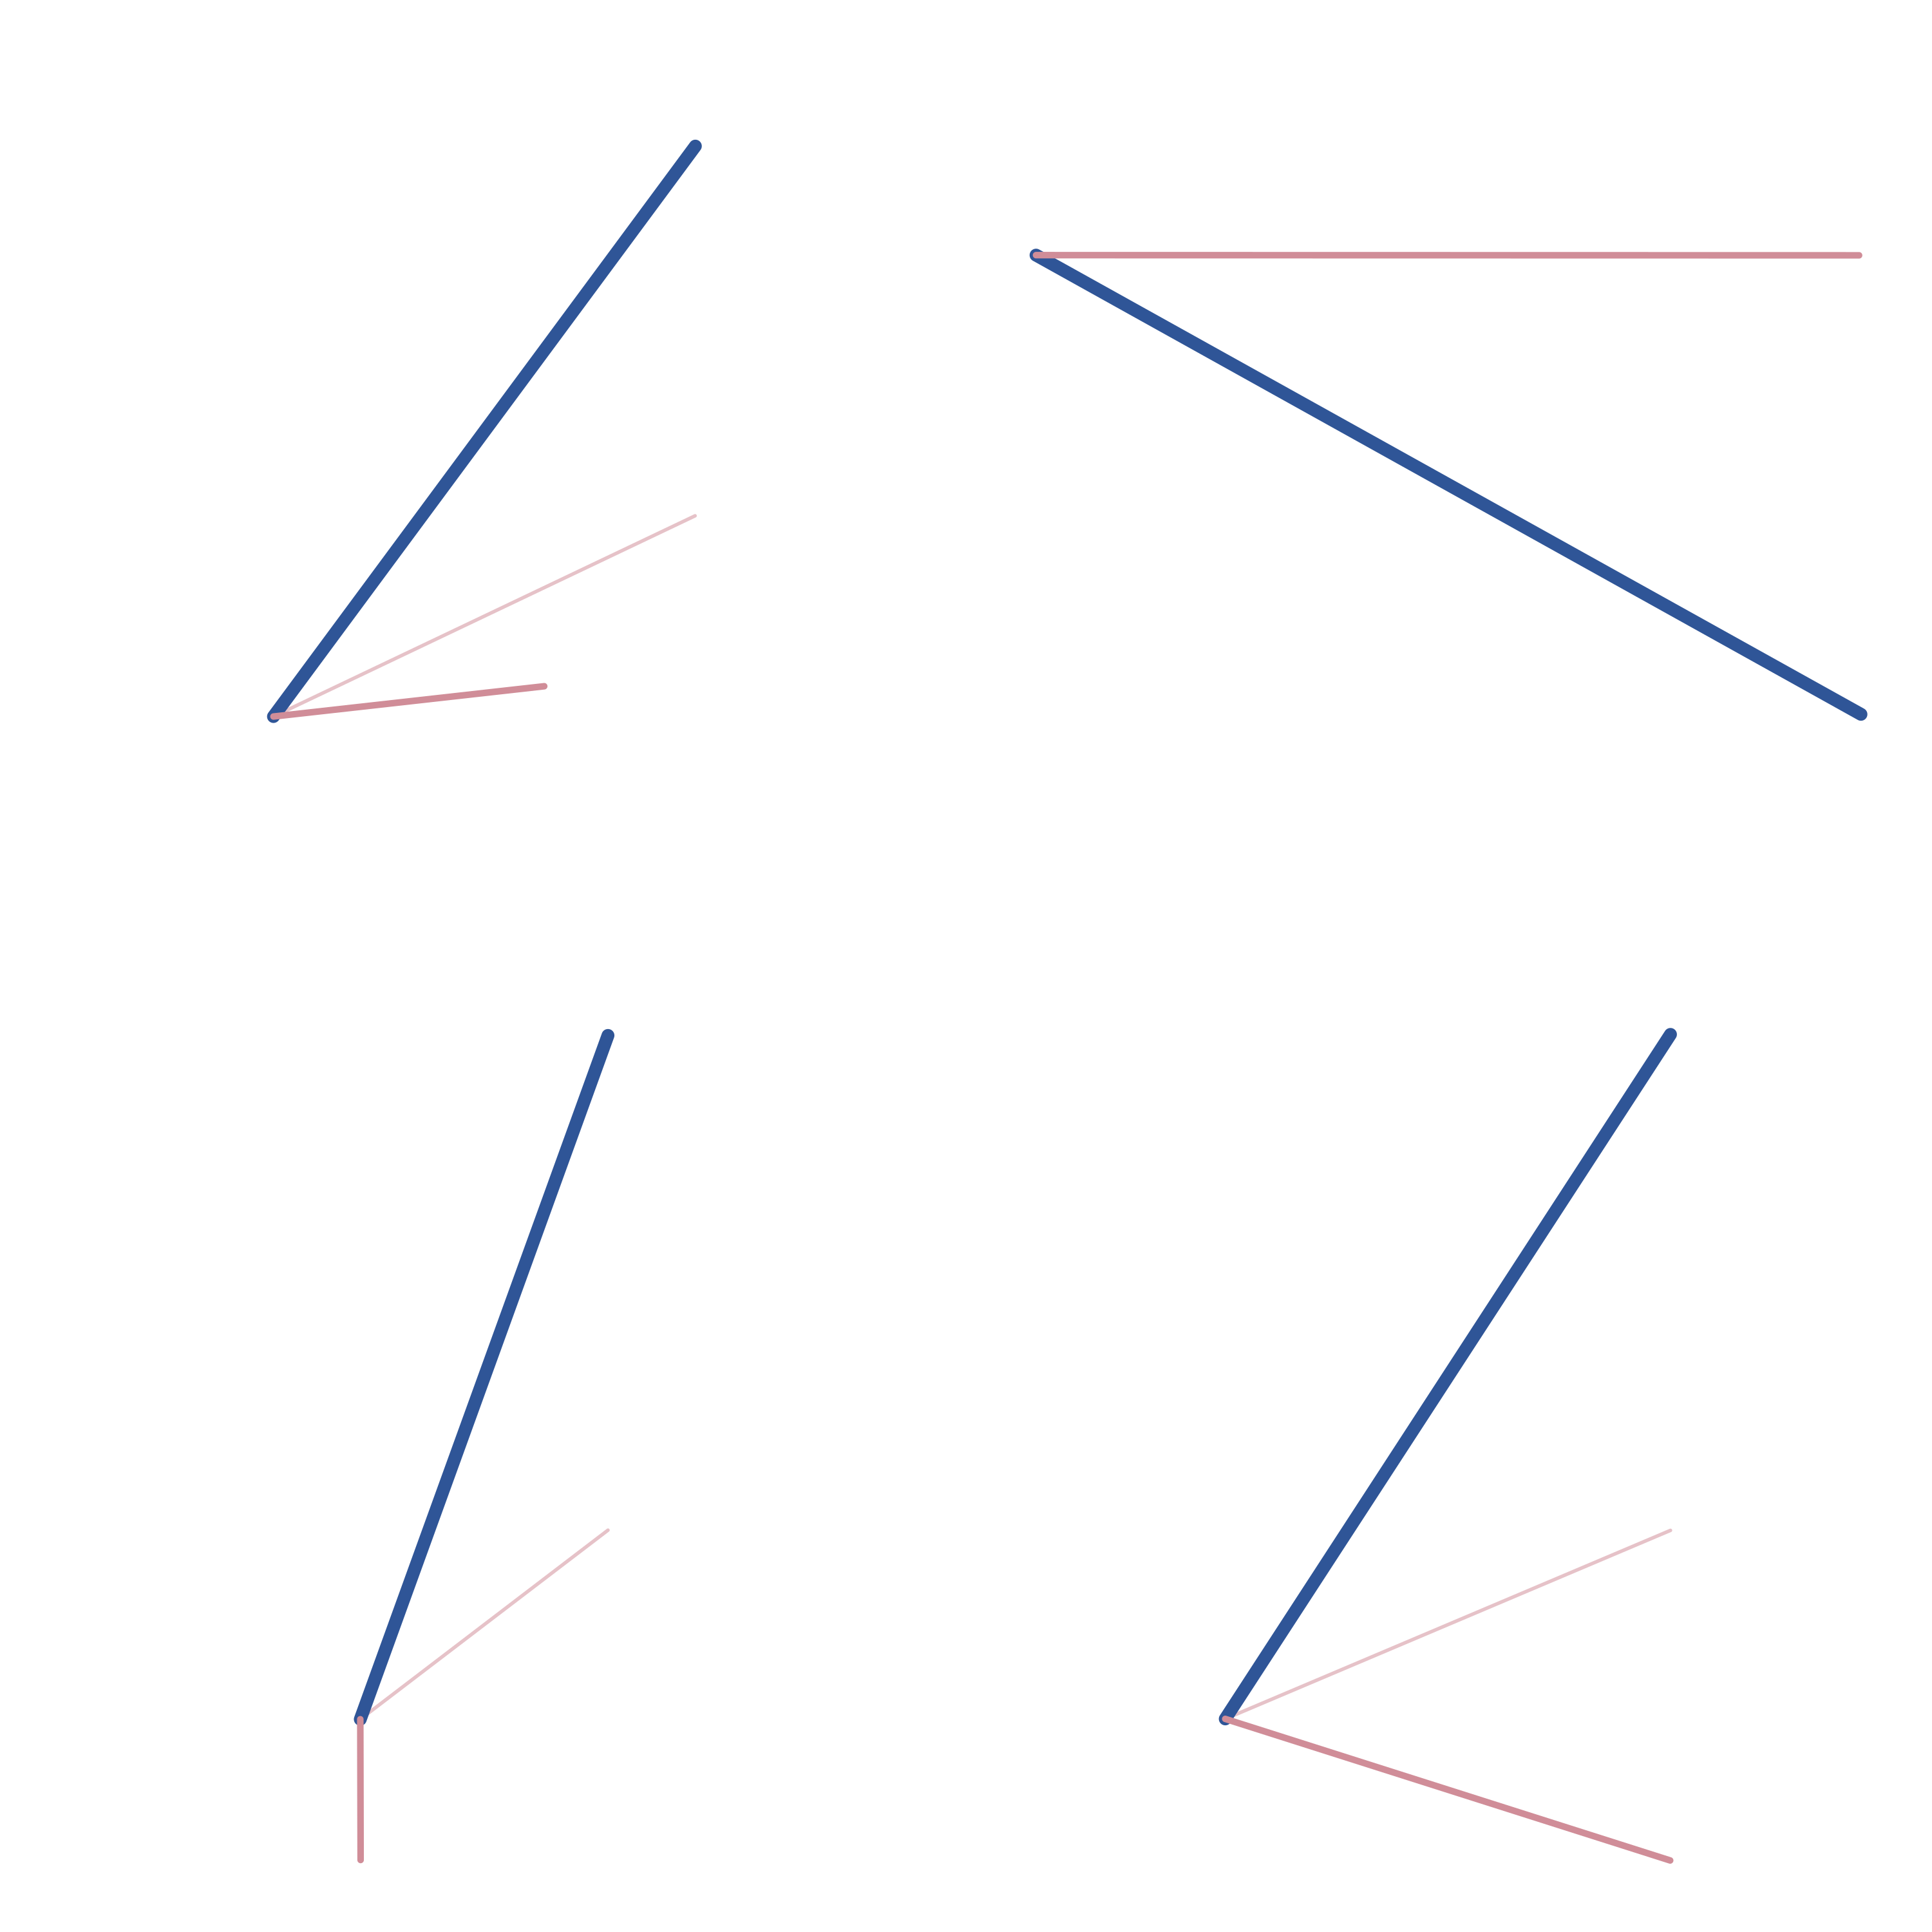

In [20]:
using CairoMakie
CairoMakie.activate!()

fig2 = axo(geo; mode = :displaced, lw = 4)

And save it!

In [22]:
save("testfig.svg", fig2)

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000005e29f3f0, 2250.0, 2250.0, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1))
